# Capstone Project 3: Custom Wind Turbine Detection using YOLOv7 Architecture

## *Notebook 3/3: Model Inference & Evalutation*

This notebook details the methods for model inference and performance evaluation using the trained YOLOv7 (You Only Look Once) object detection model weights calculated in the previous notebook ('2.0-TurbineDetection-traning-evaluation.ipynb'). 

### *Problem Addressed by the Model*

The goal of this object detection model is to quickly and accurately determine the number of wind turbines in aerial or satellite-based imagery dataset for the purpose of evaluating the number of on-shore wind turbines in the United States. When paired with a reasonably-high temporal resolution satellite or aerial imagery dataset, the growth of on-shore wind capacity over time may be constrained for a region of interest.

### *Steps Covered in this Notebook*

**0.0** &nbsp;&nbsp;Import required modules & libraries

**1.0** &nbsp;&nbsp;Load object detection model from trained weights

**2.0** &nbsp;&nbsp;Set inference image path

**3.0** &nbsp;&nbsp;Model inference
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.1**&nbsp;&nbsp;Run model inference
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**3.2**&nbsp;&nbsp;Get inference results
    
**4.0** &nbsp;&nbsp;Aggregate inference metrics & score model performance
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.1**&nbsp;&nbsp;Define helper functions
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2**&nbsp;&nbsp;Aggregate inference metrics
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.3**&nbsp;&nbsp;Score model performance

**5.0** &nbsp;&nbsp;Visualize model performance
    <br>
    
**6.0** &nbsp;&nbsp;Save & export model detections
    <br>

**7.0** &nbsp;&nbsp;Discussion of model performance & results
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**7.1**&nbsp;&nbsp;Model performance
    <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**7.2**&nbsp;&nbsp;Model application to the problem statement

### *Prerequisites to this Notebook*

This notebook requires the output weights (ex. 'best_weights.pt') from the YOLOv7 object detection model trained in the previous notebook ('2.0-TurbineDetection-traning-evaluation.ipynb').


### *Saving Model Inference Images*

See Section 6.0 for the code snippet required to export inference images to a local or hosted directory.

___

## 0.0 Import Required Modules & Libraries

In [1]:
import argparse
import time
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.backends.cudnn as cudnn
from numpy import random
import numpy as np
import os
import io
from PIL import Image

from inference import test
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

## 1.0 Load Object Detection Model from Trained Weights

In this section, the trained pytorch object detection model is loaded from a local directory via a model weights file 'best.pt', and a confidence threshold of 0.35 is assigned for confirmed detections (as determined in the previous notebook).

In [2]:
# define model weight file
model_name = 'best.pt'

# load model from saved model weights
model = torch.hub.load(os.getcwd(), 'custom', model_name, source ='local', force_reload = True)

# set model object detection confidence threshold
model.conf = 0.35


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

 76                -1  1         0  models.common.MP                        []                            
 77                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
 78                -3  1     16640  models.common.Conv                      [128, 128, 1, 1]              
 79                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
 80      [-1, -3, 63]  1         0  models.common.Concat                    [1]                           
 81                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 82                -2  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 83                -1  1    295168  models.common.Conv                      [256, 128, 3, 1]              
 84                -1  1    147712  models.common.Conv                      [128, 128, 3, 1]              
 85                -1  1    147712  m

Adding autoShape... 


## 2.0 Set Inference Image Path

In this section, the target inference image directory path is set, and the list of target images is aggregated. 

In [3]:
# set path to test (inference) image directory
test_dir = r"C:\Users\User\Desktop\Files\Springboard\Projects\Capstone_Three\data\cleaned\test\images"

# change directory to test images
%cd ..
%cd data\cleaned\test\images

C:\Users\User\Desktop\Capstone_Three
C:\Users\User\Desktop\Capstone_Three\data\cleaned\test\images


In [4]:
# get list of test (inference) image names
test_image_names = [image for image in os.listdir(test_dir)]

# print test image names
[print(name) for name in test_image_names]

forest-wind-crop-23_jpg.rf.d3f0ca7493c1bec033154f13b576977b.jpg
forest-wind-crop-9_jpg.rf.c310a43408389c48c031132a41ec1c9e.jpg
glacier-wind-crop-2_jpg.rf.db62bfccd7e7688926efe8758885ada4.jpg
naip_1101_CA_WND_i0j1_jpg.rf.eb16d83cbcbbc1556077bf1c887d87bb.jpg
naip_1133_CA_WND_i0j0_jpg.rf.6462cdc64a46164372e6200ee2d9caa2.jpg
naip_1148_CA_WND_i0j0_jpg.rf.513433545c3f4c3fc4a62ae0f62775ed.jpg
naip_1148_CA_WND_i0j1_jpg.rf.9d939b1906ac5fbef1c68aa309953473.jpg
naip_1149_CA_WND_i0j0_jpg.rf.8d51bafa4d81784a917117bfd02af8cc.jpg
naip_1149_CA_WND_i1j0_jpg.rf.73783a0dc88ada4918e9c19c68f05874.jpg
naip_1197_CA_WND_i0j1_jpg.rf.27654b4c3bf87dc13c5575aa876eda25.jpg
naip_1252_CA_WND_i1j1_jpg.rf.ca5419680784fae1f7ebe6aeb62d6284.jpg
naip_1265_CA_WND_i0j1_jpg.rf.f423ecb7b7a2cab151c7d72101d1f2ac.jpg
naip_1353_CA_WND_i0j0_jpg.rf.c8fa7b1269ff693f4d6f1644de316437.jpg
naip_1353_CA_WND_i1j1_jpg.rf.f893c740e98c2b9c61f5985d49d4cd69.jpg
naip_1423_CA_WND_i1j1_jpg.rf.50069d8b7caf2b125261edde8f9b5a02.jpg
naip_1434_CA_WND_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## 3.0 Model Inference

In the following section, the loaded object detection model runs inferences on the images within the target directory ('test_dir') and the inference times, and number of turbine detections are returned.

The resulting output, including detection bounding boxes are aggregated into a working results DataFrame ('results_df') for futher wrangling and analysis.

### 3.1 Run Model Inference

In [5]:
# run model inference on test (inference) images
test_results = [model(image, size=640) for image in os.listdir(test_dir)]

# print model inference results
[test_results[test_results.index(item)].print() for item in test_results] # or .show(), .save(), .crop(), .pandas(), etc.

image 1/1: 640x640 1 turbine
Speed: 662.4ms pre-process, 2309.3ms inference, 8.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 1 turbine
Speed: 12.0ms pre-process, 17.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 1 turbine
Speed: 9.0ms pre-process, 16.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 2 turbines
Speed: 7.0ms pre-process, 13.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 2 turbines
Speed: 5.0ms pre-process, 13.0ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 12 turbines
Speed: 5.0ms pre-process, 13.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 17 turbines
Speed: 5.0ms pre-process, 13.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 6 turbines
Speed: 5.0ms pre-process, 13.0ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 640x640 4 turbines
Speed:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### 3.2 Get Inference Results

In [6]:
# get list of model inference results
test_detections = [detection for detection in test_results]

# create empty DataFrame to store inference results
results_df = pd.DataFrame(columns = ['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name', 'image_name'])

# loop over model inference results
for i in range(len(test_detections)):
    
    # create temp DataFrame with results for each inference image
    temp = test_results[test_results.index(test_detections[i])].pandas().xyxy[0]
    
    # add additional column to store inference image name
    temp['image_name'] = test_image_names[i]
    
    # concatenate new inference result to existing inferences
    results_df = pd.concat([temp, results_df], ignore_index=False)

In [7]:
# print the inference results DataFrame
results_df

,xmin,ymin,xmax,ymax,confidence,class,name,image_name
0,448.496094,213.390625,511.778809,288.884705,0.826703,0,turbine,suburban-wind-68_jpg.rf.15928527cb9e769c4eb420...
0,437.235535,464.480408,570.150818,566.475769,0.750731,0,turbine,suburban-wind-61_jpg.rf.4282e06dbec22c2f5b928f...
0,376.900879,197.589478,435.718506,298.210266,0.523773,0,turbine,suburban-wind-5_jpg.rf.9f96ba7ba194256d2813682...
0,84.148537,17.035358,172.117584,123.229767,0.781179,0,turbine,suburban-wind-51_jpg.rf.d4a43dec1b9d89001b5187...
0,528.125977,320.288727,630.409546,431.458588,0.656468,0,turbine,suburban-wind-44_jpg.rf.ef1a57a00df868f2e5701e...
...,...,...,...,...,...,...,...,...
0,134.104614,502.985809,165.346985,521.978271,0.422777,0,turbine,naip_1101_CA_WND_i0j1_jpg.rf.eb16d83cbcbbc1556...
1,70.877365,595.190918,88.430252,608.003296,0.362600,0,turbine,naip_1101_CA_WND_i0j1_jpg.rf.eb16d83cbcbbc1556...
0,541.075378,344.375549,585.731384,419.828247,0.573345,0,turbine,glacier-wind-crop-2_jpg.rf.db62bfccd7e7688926e...
0,225.453659,242.906281,341.854218,290.726227,0.789506,0,turbine,forest-wind-crop-9_jpg.rf.c310a43408389c48c031...


## 4.0 Aggregate Inference Metrics & Score Model Performance

In the following section, the inference results acquired in section 3.2 are aggregated to acquire the number of turbine detections in each image, as well as a mean confidence metric for each inference image.

Additionally, the label data from the 'test' split is used to ground truth the number of turbines in each image and a comparision of the predicted versus actual number of turbines in each image is conducted.

### 4.1 Define Helper Functions

In [8]:
def get_images_labels(sort=True):
    """
    Returns two lists of strings: 'images', and 'labels' containing 
    filenames for images and labels in the dataset.
    
    Arguments: (1)
    1. sort: if True, returns a sorted list of images and labels
    
    Requirements: (1)
    1. Directories 'images' and 'labels' must be in the current working directory
    """
    # get list of image filenames in 'images/'
    images = [os.path.join('images', x) for x in os.listdir('images')]
    # get list of label filenames in 'labels/'
    labels = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]
    
    # sort, if required
    if sort==True:
        images.sort()
        labels.sort()
    
    return images, labels

In [9]:
def make_annotations_from_labels(labels):
    """
    Takes a list of strings referencing YOLO format .txt labels, and
    returns a DataFrame with the following columns:
    'filename', 'class', 'x', 'y', 'height', 'width'.
    
    Arguments: (1)
    1. labels: list of strings of filenames for YOLO format .txt labels
    
    Requirements: (0)
    """
    # create empty list
    annot_list = []
    
    # iterate over filenames in labels list
    for name in labels:
        
        # open the label .txt file in read configuration
        f = open(os.path.join('{}'.format(name)), 'r')
        
        # check if the .txt file is empty (is a null label)
        check_file = os.stat('{}'.format(name)).st_size
        
        # if the file isn't a null label
        if(check_file != 0):
            
            # iterate over lines in the file
            num_lines = 0
            for line in f:
                
                # split each line and extract features
                num_lines += 1
                data = line.split()
                temp = name.split('.')[0]
                filename = '{}.jpg'.format(temp.split('\\')[-1])
                
                # assign class, x, y, height, and width to variables
                cls = int(data[0])
                x = float(data[1])
                y = float(data[2])
                height = float(data[3])
                width = float(data[4])
                
                # append label data components to the annotation list 
                annot_list.append([filename, cls, x, y, height, width])
                
        # close the file
        f.close()
    
    # create a DataFrame containing all label annotation data
    annotations = pd.DataFrame(annot_list, columns=['filename','class','x', 'y', 'height', 'width'])
    return annotations

### 4.2 Aggregate Inference Metrics

In [10]:
# get DataFrame containing number of wind turbine detections by image name
detec_by_image = results_df['image_name'].value_counts().reset_index()

# get DataFrame with mean turbine detection confidence score by image name
conf_by_image = results_df.groupby('image_name')['confidence'].agg(np.mean).reset_index()

In [11]:
# rename columns for accuracy
detec_by_image.rename(columns={'index':'image_name','image_name':'turbine count (inference)'}, inplace=True)

# change image_name data type from object to string
detec_by_image['image_name'] = detec_by_image['image_name'].astype(str)

In [12]:
# join detec_by_image and conf_by_image dataframes
confidence_count = pd.merge(detec_by_image, conf_by_image, how="inner", on='image_name')

# rename column for accuracy
confidence_count.rename(columns={'confidence':'mean confidence'}, inplace=True)

In [13]:
# print first 20 records in confidence_count DataFrame
confidence_count.head(20)

,image_name,turbine count (inference),mean confidence
0,naip_1434_CA_WND_i0j1_jpg.rf.3d03a370067f02671...,40,0.635805
1,naip_1197_CA_WND_i0j1_jpg.rf.27654b4c3bf87dc13...,20,0.683460
2,naip_1148_CA_WND_i0j1_jpg.rf.9d939b1906ac5fbef...,17,0.517938
3,naip_1771_CA_WND_i1j1_jpg.rf.4720ef4be773eca44...,17,0.577337
4,naip_666_CA_WND_i1j0_jpg.rf.7581021bbf72d588dd...,17,0.516857
5,naip_1252_CA_WND_i1j1_jpg.rf.ca5419680784fae1f...,16,0.489089
6,naip_1742_CA_WND_i0j1_jpg.rf.998e7ea74238ecfbe...,16,0.542004
7,naip_1771_CA_WND_i0j1_jpg.rf.3ee734e6742aa9be3...,16,0.528881
8,naip_1148_CA_WND_i0j0_jpg.rf.513433545c3f4c3fc...,12,0.501571
9,naip_446_CA_WND_i0j0_jpg.rf.afa54619ef64903718...,9,0.534682


### 4.3 Score Model Performance

In [14]:
# change working directory to 'test' containing subfolders 'images' and 'labels'
os.getcwd()
%cd ..

# get label data from the directory
images, labels = get_images_labels()

# create annotations DataFrame from .txt files
test_annotations = make_annotations_from_labels(labels)

# return to the original 'images' directory
%cd images

C:\Users\User\Desktop\Capstone_Three\data\cleaned\test
C:\Users\User\Desktop\Capstone_Three\data\cleaned\test\images


In [15]:
# create y_test DataFrame, which contains the ground-truth number of turbines in each test image
y_test = pd.DataFrame({'turbine count (test)':test_annotations['filename'].value_counts()}).reset_index()
# rename columns for clarity
y_test.rename(columns={'index':'image_name'}, inplace=True)
# rename image names for consistency with y_pred DataFrame (for joining purposes)
y_test['image_name'] = [y_test['image_name'][i].split('.')[0] for i in range(len(y_test))]

# create y_pred DataFrame, which contains the predicted number of turbines in each test image (from model inference)
y_pred = confidence_count[['image_name','turbine count (inference)','mean confidence']]
# rename image names for consistency with y_test DataFrame (for joining purposes)
y_pred['image_name'] = [y_pred['image_name'][i].split('.')[0] for i in range(len(y_pred))]

# join y_test and y_pred dataframes
performance_df = pd.merge(y_test, y_pred, how="inner", on='image_name')

In [16]:
# show the joined model performance DataFrame
performance_df

,image_name,turbine count (test),turbine count (inference),mean confidence
0,naip_1434_CA_WND_i0j1_jpg,45,40,0.635805
1,naip_666_CA_WND_i1j0_jpg,33,17,0.516857
2,naip_1742_CA_WND_i0j1_jpg,30,16,0.542004
3,naip_1252_CA_WND_i1j1_jpg,23,16,0.489089
4,naip_1197_CA_WND_i0j1_jpg,19,20,0.683460
...,...,...,...,...
103,forest-wind-crop-9_jpg,1,1,0.789506
104,naip_4273_MN_WND_i0j1_jpg,1,1,0.627043
105,naip_3732_MA_WND_i1j1_jpg,1,1,0.610825
106,naip_368_AZ_WND_i1j1_jpg,1,1,0.743043


Next, the predicted 'turbine count (test)' and actual 'turbine count (inference)' detections are aggregated and regression model performance metrics are evaluated on the assumed linear fit. 

In [17]:
# import scikit-learn model metric modules
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# define y_test and y_pred from the number of actual and predicted turbines in each image, respectively
y_test = np.array(performance_df['turbine count (test)'])
y_pred = np.array(performance_df['turbine count (inference)'])

# calculate linear fit metrics
rsq = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# aggregate metrics into a scores DataFrame
scores = pd.DataFrame({'R-Squared': [rsq], 'MAE': [mae], 'MSE': [mse], 'MAPE': [mape]}, index=['RFR()'])

# show the calculated scores
scores

,R-Squared,MAE,MSE,MAPE
RFR(),0.800245,0.972222,9.37963,0.15964


## 5.0 Visualize Model Performance

In this section, four figures are generated to visualize model performance on the test set, including an analysis of predicted vs. actual wind turbines in the images evaluated. See comments in code for descriptions of each figure, see section 7.0 for further discussion of model performance and results.

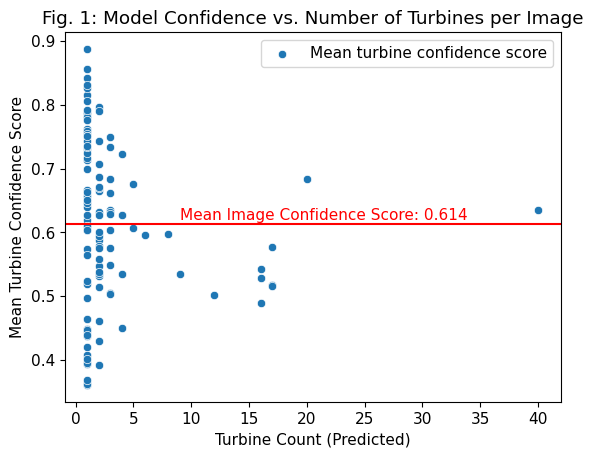

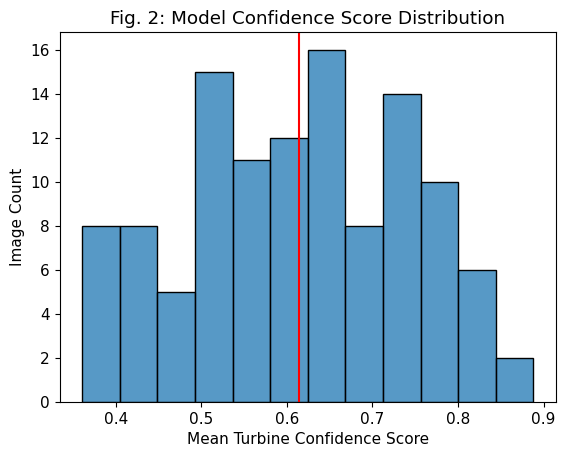

In [36]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline 

# import seaborn for improved visualizations
import seaborn as sns

# Figure 1: Scatterplot: visualization of relationship between image turbine count, and mean turbine confidence score
plt.figure()
sns.scatterplot(data=confidence_count, x='turbine count (inference)', y='mean confidence')
plt.axhline(np.mean(confidence_count['mean confidence']), c='r')
plt.text(9,0.62,'Mean Image Confidence Score: {}'.format(np.round(np.mean(confidence_count['mean confidence']),3), fontsize=6),
        c = 'red')

plt.title('Fig. 1: Model Confidence vs. Number of Turbines per Image')
plt.ylabel('Mean Turbine Confidence Score')
plt.xlabel('Turbine Count (Predicted)')
plt.legend(['Mean turbine confidence score'])
plt.show()

# Figure 2: Histogram: visualization of distribution of mean turbine confidence on all inferenced images
plt.figure()
sns.histplot(data=confidence_count, x='mean confidence', bins=12)
plt.axvline(np.mean(confidence_count['mean confidence']), c='r')

plt.title('Fig. 2: Model Confidence Score Distribution')
plt.xlabel('Mean Turbine Confidence Score')
plt.ylabel('Image Count')
plt.show()

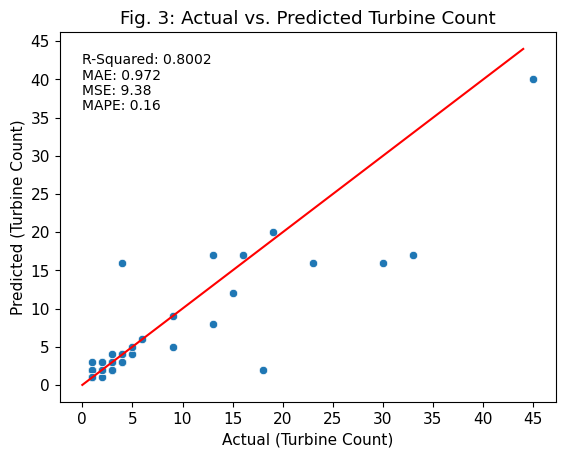

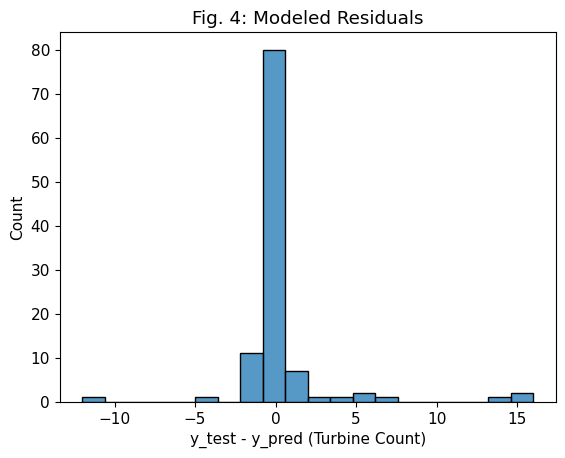

In [33]:
# Figure 3: Scatterplot: Actual vs. Predicted number of turbines in image
plt.figure()
sns.scatterplot(data=performance_df, x='turbine count (test)', y='turbine count (inference)')
plt.plot(np.arange(0,max(performance_df['turbine count (test)']), 1), 
         np.arange(0,max(performance_df['turbine count (test)']), 1), c='red')

plt.xticks(np.arange(0,max(performance_df['turbine count (test)']+5), 5))
plt.yticks(np.arange(0,max(performance_df['turbine count (test)']+5), 5))

plt.title('Fig. 3: Actual vs. Predicted Turbine Count')
plt.xlabel('Actual (Turbine Count)')
plt.ylabel('Predicted (Turbine Count)')

plt.text(0,42,'R-Squared: {}'.format(np.round(rsq,4)), fontsize=10)
plt.text(0,40,'MAE: {}'.format(np.round(mae,3)), fontsize=10)
plt.text(0,38,'MSE: {}'.format(np.round(mse,3)), fontsize=10)
plt.text(0,36,'MAPE: {}'.format(np.round(mape,3)), fontsize=10)
plt.show()

# create modeled residuals dataframe
residuals = pd.DataFrame({'residual':y_test-y_pred})

# Figure 4: Histogram: Distribution of modeled residuals
plt.figure()
sns.histplot(data=residuals, x='residual', bins=20)

plt.title('Fig. 4: Modeled Residuals')
plt.xlabel('y_test - y_pred (Turbine Count)')
plt.show()

## 6.0 Save & Export Model Detections

In [20]:
# change directory to results/detections/ to save inference images
%cd ..
%cd ..
%cd ..
%cd results/detections

# save detections to current directory ('/detections')
[test_results[test_results.index(item)].save() for item in test_results] 

In [21]:
# change directory to results/
%cd ..

# Export model metrics for inferences on test set - columns:(image, y_test, y_pred, confidence CSV)
performance_df.to_csv('model_metrics_PredictedVsActual.csv')

# Export y_test vs. y_pred model fit metricsL: - columns:(R-Squared, MAE, MSE, MAPE)
scores.to_csv('model_metrics_ModelFit.csv')

## 7.0 Discussion of Model Performance & Results

### 7.1 Model Performance 

As recorded in notebook 2/3 in this repository ('2.0-TurbineDetection-traning-evaluation'), the final YOLOv7 object detection model (trained on 4,600 aerial images), achieved 0.651 mean average precision (mAP) at 0.5 intersection-over-union (IoU). Due to the low number of classes (1) labeled in the training data, mAP was selected as the most meaningful object detection performance metric.

The quality of inferences produced at mAP=0.651 are visualized most succinctly in Figure 3 above ('Actual vs. Predicted Turbine Count'). The model is shown to achieve the highest R<sup>2</sup> (best fit) when inferencing on images with fewer than roughly 10 turbines in view. This is corroborated by Figure 1, where the highest values in mean confidence score are distributed disproportionately among images with fewer than 10 turbines.


### 7.2 Model Application to the Problem Statement

For the problem of generating quick and accurate estimates of the count of on-shore wind turbines, this model achieves a reasonably high degree of success (mean absolute error per image: 0.972 turbines) and fast inference times (15 ms/image) on a mid-level NVIDIA RTX 3070 Ti GPU. Given the current estimate of on-shore wind turbines in the U.S. (roughly 70,800 - [U.S. Geological Survey](https://www.usgs.gov/faqs/how-many-turbines-are-contained-us-wind-turbine-database#:~:text=Frequently%20Asked%20Questions-,How%20many%20turbines%20are%20contained%20in%20the%20U.S.%20Wind%20Turbine,plus%20Puerto%20Rico%20and%20Guam)), inference calculations for every turbine in the U.S. would take ~18 minutes of compute time assuming one turbine per image.   

The primary application for this model would be in acquiring leading estimates of on-shore wind turbine numbers given the quarterly (3-month) lag in update frequency for state-of-the-art wind turbine databases such as the [U.S. Wind Turbine Database](https://eerscmap.usgs.gov/uswtdb/) maintained by the U.S. Geological Survey.

Future development could include significant training dataset augmentation. Examples of this may be the addition of off-shore wind turbine images, or the addition of biome classification to identify backgrounds within which the model performs more poorly. Other development could include new class additions (ex. solar arrays) for use cases related to total renewables generation capacity estimation.
























